In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Plot style
sns.set_theme(style="whitegrid")


In [ ]:
# load dataset with moderate churn rate
df = pd.read_csv("../data/user_activity.csv")
df.head()


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
0,1,132,5,4,10.32,0,0,0
1,2,465,196,6,16.32,1,0,0
2,3,890,132,7,19.03,1,0,0
3,4,300,258,3,13.04,1,0,0
4,5,136,22,3,17.77,0,0,0


In [40]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            1000 non-null   int64  
 1   signup_days_ago        1000 non-null   int64  
 2   last_active_days_ago   1000 non-null   int64  
 3   num_logins_last_month  1000 non-null   int64  
 4   avg_session_length     1000 non-null   float64
 5   num_support_tickets    1000 non-null   int64  
 6   is_premium             1000 non-null   int64  
 7   churned                1000 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 62.6 KB


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
count,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000
mean,500.500000,519.80400,145.63900,4.922000,14.988530,0.498000,0.284000,0.2000
std,288.819436,283.76346,89.02159,2.208799,4.872162,0.700347,0.451162,0.4002
min,1.000000,30.00000,0.00000,0.000000,-2.330000,0.000000,0.000000,0.0000
25%,250.750000,262.00000,67.00000,3.000000,11.607500,0.000000,0.000000,0.0000
50%,500.500000,525.50000,146.50000,5.000000,15.105000,0.000000,0.000000,0.0000
75%,750.250000,768.00000,224.25000,6.000000,18.372500,1.000000,1.000000,0.0000
max,1000.000000,999.00000,299.00000,15.000000,28.990000,4.000000,1.000000,1.0000


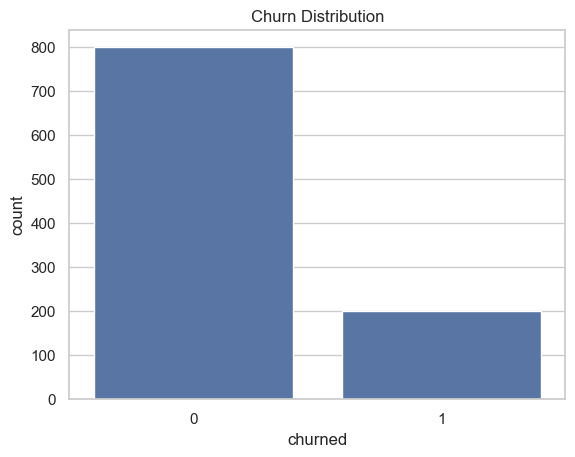

In [41]:
# Quick EDA

sns.countplot(x="churned", data=df)
plt.title("Churn Distribution")
plt.show()


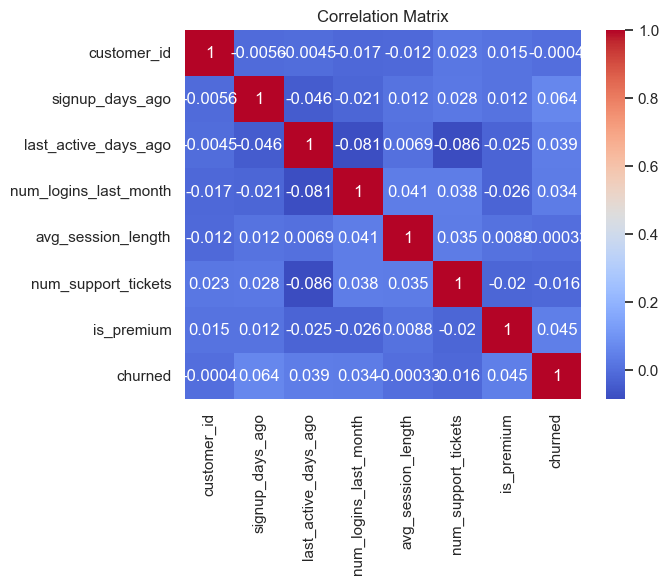

In [42]:
# check correlation

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [43]:
# feature prep

X = df.drop(columns=["customer_id", "churned"])
y = df["churned"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


#### Choice Of Base Model & Evaluation Metrics:

#### ✅ Churn Model Metrics
Choose metrics based on current priority

| Metric                                    | Why It's Useful                                                     | When to Use                                                                         |
| ----------------------------------------- | ------------------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| **Recall (Sensitivity)**                  | Measures how many actual churners you caught                        | Most important when false negatives are costly (missing a churner = lost customer)  |
| **Precision**                             | Measures how many of the predicted churners really churned          | Important if actions are expensive (e.g., offering discounts only to real churners, not annoying loyal customers with unnecessary retention actions) |
| **F1 Score**                              | Harmonic mean of precision and recall                               | Useful when you want a balance between precision and recall                         |
| **ROC AUC Score**                         | Measures how well the model ranks positives over negatives          | Great for overall model evaluation and comparison                                   |
| **PR AUC Score** *(Precision-Recall AUC)* | Better than ROC AUC in highly imbalanced settings                   | Especially useful when positive class (churn) is rare                               |
| **Confusion Matrix**                      | Gives raw counts of TP, FP, FN, TN                                  | Useful for stakeholder communication                                                |
| **Lift at K / Top-K Recall**              | Tells you how many churners you caught in the top-scoring customers | Great for marketing prioritization (e.g., top 10% most likely churners)             |


❌ __Accuracy:__ Misleading in imbalanced datasets. If 90% don’t churn in learning data, a model predicting “no churn” for everyone will still be 90% accurate — but useless.


##### 📖 Churn Model Metrics Interpretation

| Metric               | What It Means                                       | Good Sign                          | Bad Sign                          | Special Notes for Churn                   |
| -------------------- | --------------------------------------------------- | ---------------------------------- | --------------------------------- | ----------------------------------------- |
| **Accuracy**         | % of all predictions that are correct               | >90%                               | Often misleading                  | Ignore this for churn (imbalanced data)   |
| **Precision**        | Of all predicted churners, how many really churned? | High = you don’t annoy loyal users | Low = unnecessary retention costs | Important if retention actions are costly |
| **Recall**           | Of all real churners, how many did you catch?       | High = saves more customers        | Low = lost churners               | Most important in churn prevention        |
| **F1 Score**         | Balance of precision & recall                       | High = good tradeoff               | Low = biased model                | Use when both precision & recall matter   |
| **ROC AUC**          | How well does model rank churners vs. non-churners? | Close to 1.0                       | 0.5 = random guessing             | Good general performance metric           |
| **PR AUC**           | Area under Precision-Recall curve                   | High = effective for rare churn    | Low = poor signal on rare events  | Better than ROC AUC for rare churn        |
| **Confusion Matrix** | Raw count of TP, FP, FN, TN                         | -                                  | -                                 | Shows real-world mistakes                 |
| **Lift / Top-K**     | Not in this code, but useful for marketing          | -                                  | -                                 | Can be added later                        |
  
     
        
---  
  
### 🔥 How Rare Is "Rare"? Hold My Stake
| Churn Rate | Model                                         | Technique                     | Key Metric                |
| ---------- | --------------------------------------------- | ----------------------------- | ------------------------- |
| **< 20%**  | `LogisticRegression(class_weight='balanced')` | Balanced class weights        | ROC AUC + F1              |
| **< 10%**  | `SMOTE + LogisticRegression`                  | Oversampling + scaling        | PR AUC + F1               |
| **< 5%**   | `SMOTE + XGBClassifier(scale_pos_weight=...)` | Advanced model + class weight | PR AUC + threshold tuning |


##### 🟡 Scenario 1: Moderately Imbalanced (Churn < 20%)
✅ Recommended Baseline Model: Logistic Regression for good interpretability of the coefficients, balanced class weights to penalize mistakes on minority class (churn)

In [44]:
model = LogisticRegression( 
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Model Evaluation:

In [45]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.54      0.65       160
           1       0.22      0.50      0.30        40

    accuracy                           0.54       200
   macro avg       0.51      0.52      0.48       200
weighted avg       0.69      0.54      0.58       200

Confusion Matrix:
 [[87 73]
 [20 20]]
ROC AUC: 0.5403125
Precision: 0.21505376344086022
Recall: 0.5
F1 Score: 0.3007518796992481


Use ROC AUC, F1, and confusion matrix to check early-stage model performance. PR AUC optional

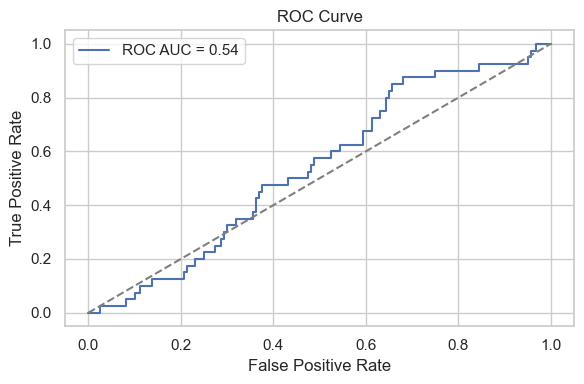

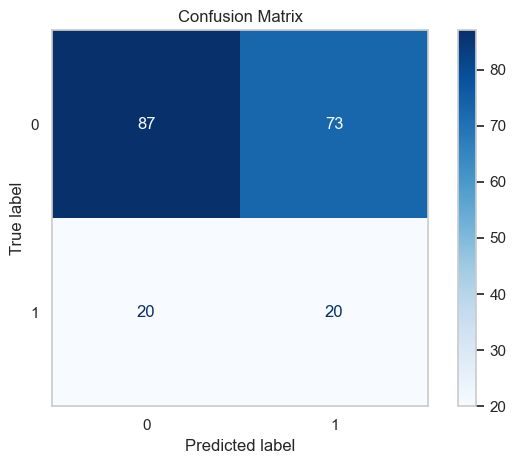

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


##### 🟠 Scenario 2: Highly Imbalanced (Churn < 10%)
✅ Recommended Baseline Model:

In [47]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

smote_model = make_pipeline(
    SMOTE(random_state=42),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)

smote_model.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [48]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score # This is new
)
y_pred = smote_model.predict(X_test)
y_proba = smote_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("PR AUC:", average_precision_score(y_test, y_proba)) # Precision-Recall AUC becomes important now, 
                                                           # keep an eye out for false positives -- you don't
                                                           # wanna annoy loyal customers with churn warnings
                                                           # Optional threshold tuning later

              precision    recall  f1-score   support

           0       0.80      0.54      0.64       160
           1       0.20      0.45      0.27        40

    accuracy                           0.52       200
   macro avg       0.50      0.49      0.46       200
weighted avg       0.68      0.52      0.57       200

Confusion Matrix:
 [[86 74]
 [22 18]]
ROC AUC: 0.5190625
Precision: 0.1956521739130435
Recall: 0.45
F1 Score: 0.2727272727272727
PR AUC: 0.22456737534293725


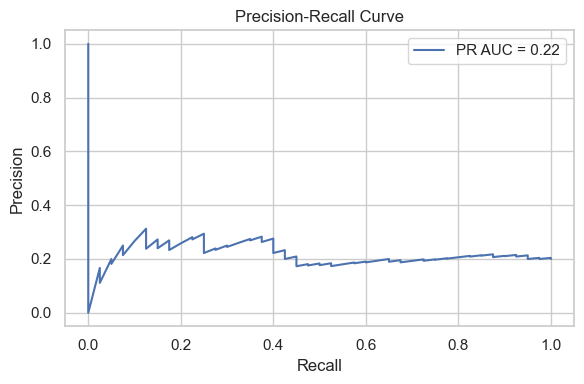

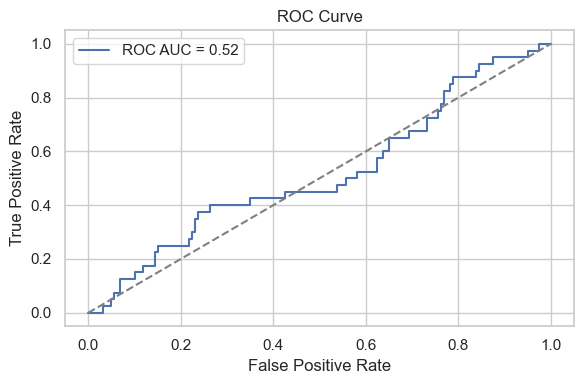

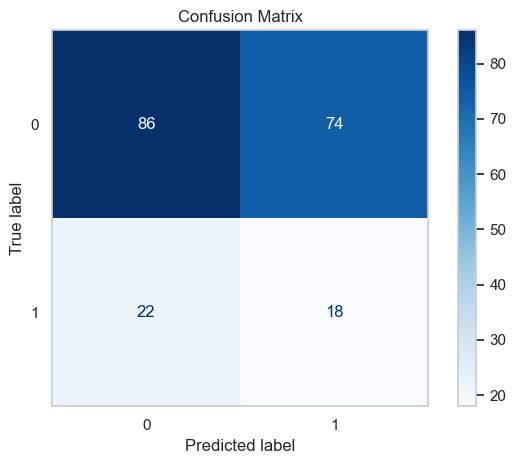

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR AUC = {average_precision_score(y_test, y_proba):.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


##### 🔴 Scenario 3: Rare Event (Churn < 5%)
✅ Recommended Baseline Model:
* scale_pos_weight compensates for extreme imbalance.
* XGBoost handles imbalance very well and gives feature importances.
* SMOTE ensures training data is more balanced.

In [50]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

xgb_smote_model = XGBClassifier(
    scale_pos_weight=(len(y_resampled) - sum(y_resampled)) / sum(y_resampled),
    # use_label_encoder=False, # This is deprecated in newer versions of XGBoost
    eval_metric='logloss',
    random_state=42
)
xgb_smote_model.fit(X_resampled, y_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Model Evaluation:

In [51]:
y_pred = xgb_smote_model.predict(X_test)
y_proba = xgb_smote_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75       160
           1       0.19      0.28      0.23        40

    accuracy                           0.62       200
   macro avg       0.50      0.49      0.49       200
weighted avg       0.68      0.62      0.65       200

Confusion Matrix:
 [[114  46]
 [ 29  11]]
ROC AUC: 0.5700000000000001
PR AUC: 0.2263160268310223


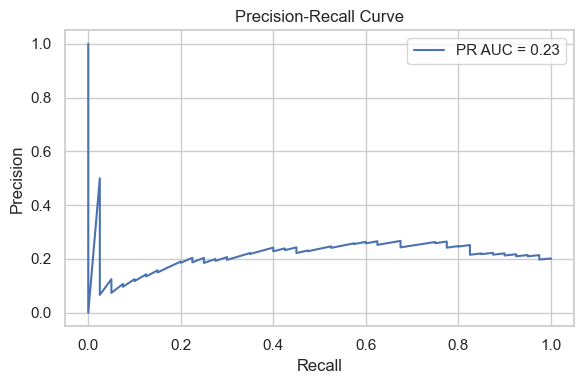

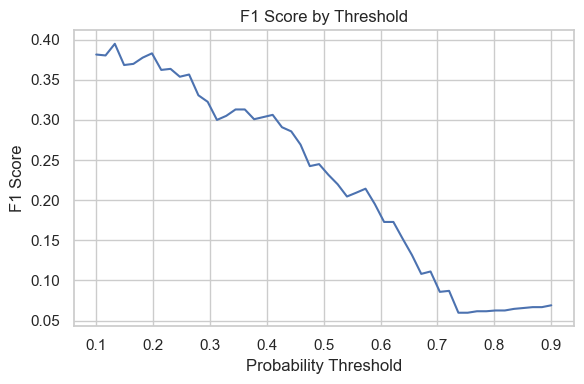

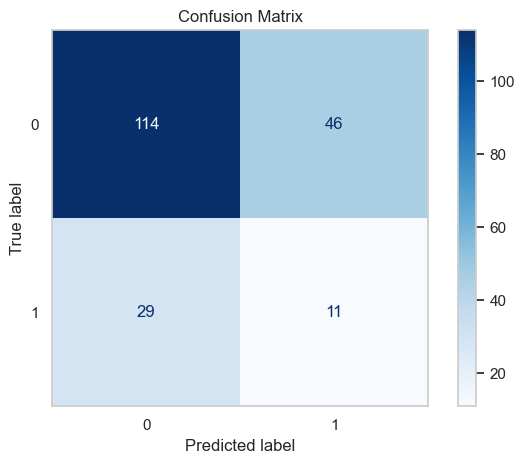

In [52]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR AUC = {average_precision_score(y_test, y_proba):.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Threshold vs. F1 Score
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores)
plt.title("F1 Score by Threshold")
plt.xlabel("Probability Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix (with default threshold)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


🔧 __Optional: Adjust Threshold__  
If you want to manually set a threshold to be more aggressive catching churners:

In [53]:
y_pred_custom = (y_proba >= 0.3).astype(int)  # Lower threshold

print("Recall (threshold 0.3):", recall_score(y_test, y_pred_custom))


Recall (threshold 0.3): 0.475


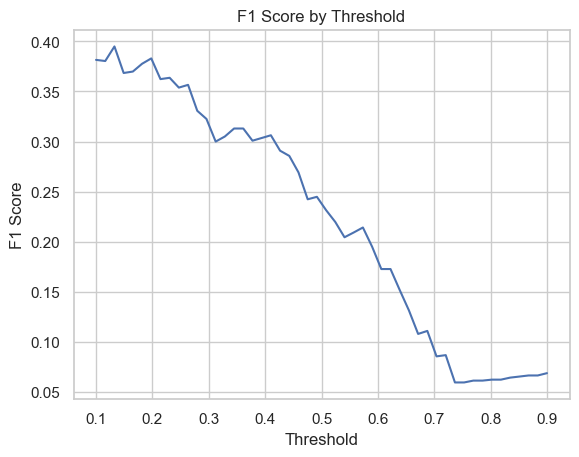

In [54]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

plt.plot(thresholds, f1_scores)
plt.title("F1 Score by Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()
